In [ ]:
from sklearn import datasets
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import tree

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/KaiSun19/EnergyScor/data/titanic.csv")

In [ ]:
data = data.replace({'Not Available': np.nan})

In [ ]:
drop_columns = ['PassengerId','Cabin', 'Ticket', "Name"]

In [ ]:
# drop index and uncorrelated data 
data = data.drop(columns = drop_columns, axis=1 )

In [ ]:
print(data)

      Survived  Pclass     Sex   Age  SibSp  Parch      Fare Embarked
0            0       3    male  22.0      1      0    7.2500        S
1            1       1  female  38.0      1      0   71.2833        C
2            1       3  female  26.0      0      0    7.9250        S
3            1       1  female  35.0      1      0   53.1000        S
4            0       3    male  35.0      0      0    8.0500        S
...        ...     ...     ...   ...    ...    ...       ...      ...
1304         0       3    male   NaN      0      0    8.0500        S
1305         1       1  female  39.0      0      0  108.9000        C
1306         0       3    male  38.5      0      0    7.2500        S
1307         0       3    male   NaN      0      0    8.0500        S
1308         0       3    male   NaN      1      1   22.3583        C

[1309 rows x 8 columns]


In [ ]:
# select data that is numeric 
for col in list(data.columns):
  if "Survived" in col or "Pclass" in col or "Age" in col or "SibSp" in col or "Parch" in col or "Fare" in col:
    data[col] = data[col].astype(float)

In [ ]:
# renaming survived data to make it easier for identification 
data = data.rename(columns = {"Survived" : "Score"})

In [ ]:
# seeing distributions of values and checking for outliers
data.hist(bins=50, figsize=(20,20))

In [ ]:
upper_quartile= data['Fare'].describe()["75%"]
lower_quartile= data['Fare'].describe()["25%"]
iqr = upper_quartile - lower_quartile
data = data[(data['Fare'] > (lower_quartile - 3 * iqr)) &
            (data['Fare'] < (upper_quartile + 3 * iqr))]

In [ ]:
# concetating numerical features and dummy variables 
numeric_subset = data.select_dtypes("number")
categoric_columns = data[["Sex", "Embarked"]]
categoric_subset = pd.get_dummies(categoric_columns)
features = pd.concat([numeric_subset, categoric_subset], axis = 1 )

In [ ]:
# drop rows that do not have a score 
features = features.dropna(subset=["Score"])

In [ ]:
# see feature importances
correlations = features.corr()['Score'].dropna().sort_values()

In [ ]:
# see correlation matrix between feature variables 
x = features.drop(columns=["Score"])
corr_matrix = x.corr()

In [ ]:
# drop multi correlated features
features = features.drop(columns =  ['Embarked_C', "Sex_male"])

In [ ]:
X = features.drop(columns = ["Score"])

In [ ]:
y = features["Score"]

In [ ]:
X, X_test, y, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [ ]:
# impute missing data 
imputer = Imputer(strategy='median')
imputer.fit(X)
X = imputer.transform(X)
X_test = imputer.transform(X_test)

In [ ]:
# scale features 
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X)
X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [ ]:
# confirm that features have no nan values
no_val = np.isnan(X).any()

In [ ]:
# create labels 
y = np.array(y).reshape((-1, ))
y_test = np.array(y_test).reshape((-1, ))

In [ ]:
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [ ]:
print(len(y_test))

368


In [ ]:
def fit_and_evaluate(model):
    model.fit(X, y)
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
    return model_mae

In [ ]:
# creates instances of models with default parameters and then evaluates them 
logr = LogisticRegression()
logr_mae = fit_and_evaluate(logr)
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)
svm = SVR(C = 1000, gamma 0.1)
svm_mae = fit_and_evaluate(svm)
random_forest = RandomForestRegressor(random_state=60)
random_forest_mae = fit_and_evaluate(random_forest)
gradient_boosted = GradientBoostingRegressor(random_state=60)
gradient_boosted_mae = fit_and_evaluate(gradient_boosted)
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae = fit_and_evaluate(knn)

In [ ]:
# creates a dataframe of model mae comparisions
model_comparision = pd.DataFrame({
    "model" : ["Logistic Regression", 'Linear Regression', 'Support Vector Machine',
                                           'Random Forest', 'Gradient Boosted',
                                            'K-Nearest Neighbors'],
    "mae" : [logr_mae, lr_mae, svm_mae,random_forest_mae, gradient_boosted_mae, knn_mae]
})

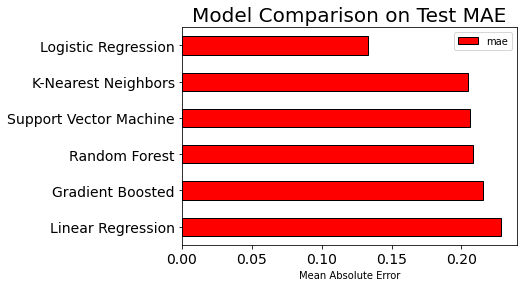

In [ ]:
model_comparision.sort_values(by="mae", ascending=False).plot(x="model", y="mae", kind="barh", color="red", 
                                                                edgecolor= "black")
plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('Mean Absolute Error'); plt.xticks(size = 14)
plt.title('Model Comparison on Test MAE', size = 20)

In [ ]:
# creates a grid for hyperparameters of the logistic regressor 
C_grid  = { "C" : [0.001,0.01,0.1,1,10,100,1000]}
model = LogisticRegression()
random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=C_grid,
                               cv=4, n_iter=25, 
                               scoring = 'neg_mean_absolute_error',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True,
                               random_state=42)
random_cv.fit(X, y)

In [ ]:
# tuned model 
model = LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# create updated predictions 
model.fit(X,y)
y_pred = model.predict(X_test)

In [ ]:
# create actual and predicted counts of positive and negative outcomes
pred_counts = np.unique(y_pred, return_counts=True)[1]
actual_counts = np.unique(y_test, return_counts=True)[1]

In [ ]:
# classification report 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.95      0.90       240
         1.0       0.89      0.70      0.79       128

    accuracy                           0.87       368
   macro avg       0.87      0.83      0.84       368
weighted avg       0.87      0.87      0.86       368



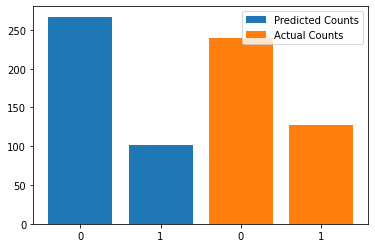

In [ ]:
# bar charts showing counts of actual and predicted outcomes 
fig, ax = plt.subplots()
n_groups = 2 
index = np.arange(n_groups)
rects1 = plt.bar(index, pred_counts,   label = "Predicted Counts")
rects2 = plt.bar(index + 2  , actual_counts, label = "Actual Counts")
plt.xticks(np.arange(4), [0,1,0,1])
plt.legend()
plt.show()

In [ ]:
# rates feature importances based on their weightings 
importances = np.abs(model.coef_[0])
feature_list = list(features.columns)[1:]
feature_results = pd.DataFrame({"Features": feature_list, 
                                "Importance": importances}).sort_values(by="Importance", ascending=False)
print(feature_results)

     Features  Importance
5  Sex_female    3.621186
2       SibSp    3.166166
1         Age    2.763609
0      Pclass    1.755548
4        Fare    1.109088
3       Parch    1.038870
7  Embarked_S    0.529901
6  Embarked_Q    0.044002
